# Set up workspace

In [1]:
## options: https://github.com/microsoft/vscode-jupyter/wiki/Using-%25matplotlib-widget-instead-of-%25matplotlib-notebook,tk,etc
%matplotlib widget

## for online
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
## load modules
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import combinations
from scipy.spatial import KDTree

# Useful functions

In [3]:
def gyroid(x, y, z):
    return np.cos(x) * np.sin(y) + np.cos(y) * np.sin(z) + np.cos(z) * np.sin(x)

def getFlatNUniqueList(lol):
    return list(set([
        elem
        for inner_list in lol
        for elem in inner_list
    ]))

def genPointCloud(implicit_func=gyroid, res=100):
    ## define domain range
    xmin, xmax = -np.pi, np.pi
    ymin, ymax = -np.pi, np.pi
    zmin, zmax = -np.pi, np.pi
    ## generate a grid of points
    x_3d, y_3d, z_3d = np.meshgrid(
        np.linspace(xmin, xmax, res),
        np.linspace(ymin, ymax, res),
        np.linspace(zmin, zmax, res)
    )
    ## compute gyroid function at each point in domain
    F = implicit_func(x_3d, y_3d, z_3d)
    ## extract the gyroid isosurface
    verts, faces, normals, values = measure.marching_cubes(F, 0)
    ## return useful mesh information
    return verts, faces, normals

def genAdjDict(verts, faces):
    num_points = verts.shape[0]
    num_faces = faces.shape[0]
    ## initialise adjacency dictionary
    dict_adj = {}
    ## for each point store the list of point indices that are connected to it
    for point_index in range(num_points):
        dict_adj[point_index] = getFlatNUniqueList([
            [
                elem
                for elem in faces[face_index]
                if not (elem == point_index)
            ]
            for face_index in range(num_faces-1)
            if point_index in faces[face_index]
        ])
    ## return adjacency dictionary
    return dict_adj

def drawSurfaceMesh(ax, verts, faces):
    num_points = verts.shape[0]
    num_faces = faces.shape[0]
    ## draw points
    ax.plot(verts[:,0], verts[:,1], verts[:,2], color="black", marker=".", ms=1, ls="")
    ## draw conective mesh
    for face_index in range(num_faces-1):
        for comb_pair in list(combinations(faces[face_index], 2)):
            ax.plot(
                [ verts[comb_pair[0],0], verts[comb_pair[1],0] ],
                [ verts[comb_pair[0],1], verts[comb_pair[1],1] ],
                [ verts[comb_pair[0],2], verts[comb_pair[1],2] ],
                color="black", ls="-", lw=0.1
            )

def drawAdjPoints(ax, dict_adj, verts, point_index=0):
    ## draw point and its adjacent points
    adj_indices_grouped = dict_adj[point_index]
    ax.plot(verts[point_index,0], verts[point_index,1], verts[point_index,2], "r.")
    for adj_index in adj_indices_grouped:
        ax.plot(verts[adj_index,0], verts[adj_index,1], verts[adj_index,2], "b.")

# Computing adjacency dictionary

[8, 10, 13]
[[0.23395555 1.         8.        ]
 [0.810402   0.         8.        ]
 [0.         1.         8.189598  ]]


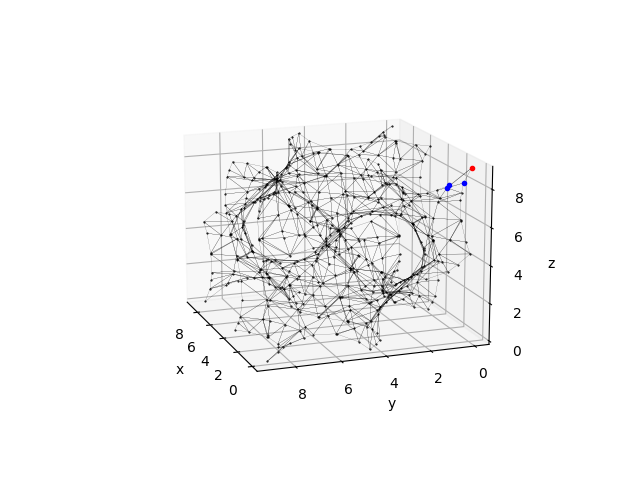

In [4]:
## generate data
verts, faces, normals = genPointCloud(implicit_func=gyroid, res=10)
dict_adj = genAdjDict(verts, faces)


plt.close("all")
## create figure canvas and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
## draw data
drawSurfaceMesh(ax, verts, faces)
i = 12
drawAdjPoints(ax, dict_adj, verts, point_index=i)
print(dict_adj[i])
print(verts[dict_adj[i],:])
## label axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
## show figure
ax.view_init(15, 160)
# fig.show()

# Computing geodesics on isosurface meshes

first point: 0.000, 0.514, 9.000
last point:  19.000, 18.486, 10.000
Solving maze...
Found 1 possible solution(s)!


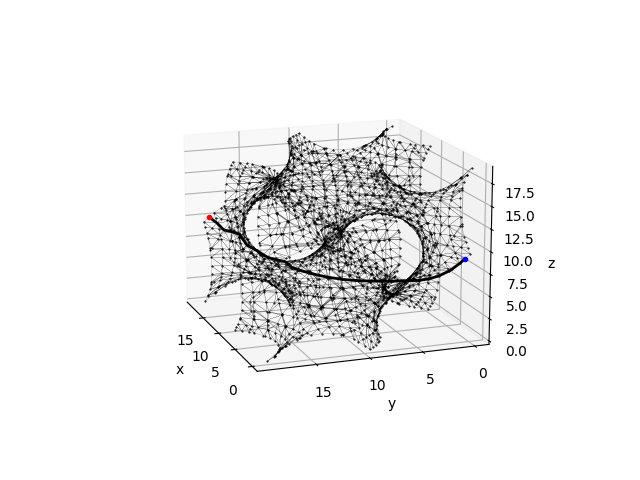

In [5]:
class Node():
  def __init__(self, parent_node=None, vi=None):
    self.parent_node = parent_node
    self.vi = vi # list of vertices index (vi)
    self.dist_trvld = 0 # distance from start
    self.dist_to_go = 0 # distance to goal
    self.total_dist = 0 # combined distances

  def __eq__(self, other) -> bool:
    if not isinstance(other, Node): return False
    return self.vi == other.vi
  
  def __le__(self, other) -> bool:
    if not isinstance(other, Node): return False
    return self.total_dist < other.total_dist

  def __gt__(self, other) -> bool:
    if not isinstance(other, Node): return False
    return self.total_dist > other.total_dist

  def __repr__(self) -> str:
    return f"vertex index = {self.vi}"

  def __str__(self) -> str:
    return f"vertex index = {self.vi}"


def printPoint(point, pre=""):
  print(f"{pre}{point[0]:.3f}, {point[1]:.3f}, {point[2]:.3f}")

def euclidean(pos1, pos2):
  return np.sqrt(
    (pos2[0] - pos1[0])**2 +
    (pos2[1] - pos1[1])**2 +
    (pos2[2] - pos1[2])**2
  )

def aStar(verts, dict_adj, first_vi, last_vi) -> list:
  ## create start and finish nodes
  first_node = Node(vi = first_vi)
  last_node  = Node(vi = last_vi)
  ## initialize empty lists
  list_opened_nodes  = []
  list_closed_nodes  = []
  soln_paths_grouped = []
  soln_costs_grouped = []
  ## initialise the open list with the start cell
  list_opened_nodes.append(first_node)
  ## search until the shortest solution has been found
  while len(list_opened_nodes) > 0:
    ## GRAB THE NEXT MOST FAVOURABLE CELL
    ## ==================================
    current_ni = 0 # list of nodes index (ni)
    current_node : Node = list_opened_nodes[0]
    for node_ni, node in enumerate(list_opened_nodes):
      if (node < current_node):
        current_ni   = node_ni
        current_node = node
    ## remove the current node from the open list
    list_opened_nodes.pop(current_ni)
    ## CHECK IF THE GOAL HAS BEEN REACHED
    ## ==================================
    if current_node == last_node:
      soln_path = []
      ## trace solution path backwards from last to start node
      prev_node : Node = current_node
      while prev_node is not None:
        soln_path.append(verts[prev_node.vi,:])
        prev_node = prev_node.parent_node
      ## store solution details
      soln_paths_grouped.append(soln_path[::-1])
      soln_costs_grouped.append(current_node.total_dist)
    ## GENERATE LIST OF NEIGHBOURING POINTS
    ## ====================================
    for neighbour_vi in dict_adj[current_node.vi]:
      neighbour_node = Node(
        parent_node = current_node,
        vi          = neighbour_vi
      )
      ## define score values
      step_size = euclidean(
        verts[current_node.vi,:],
        verts[neighbour_node.vi,:]
      )
      dist_to_go = euclidean(
        verts[neighbour_node.vi,:],
        verts[last_node.vi,:]
      )
      neighbour_node.dist_trvld = current_node.dist_trvld + step_size
      neighbour_node.dist_to_go = dist_to_go
      neighbour_node.total_dist = neighbour_node.dist_trvld + neighbour_node.dist_to_go
      ## check that the neighbour is not already in the open list
      if any([
        (node == neighbour_node) and (node < neighbour_node)
        for node in list_opened_nodes
      ]): continue
      ## check that the neighbour is not already in the closed list
      if any([
        (node == neighbour_node) and (node < neighbour_node)
        for node in list_closed_nodes
      ]): continue
      ## if the neighbour is in either the open or closed lists,
      ## then only consider it again if the score has improved
      list_opened_nodes.append(neighbour_node)
    ## add the node to the closed list
    list_closed_nodes.append(current_node)
  ## return solutions
  return soln_paths_grouped, soln_costs_grouped


plt.close("all")


## generate data
verts, faces, _ = genPointCloud(implicit_func=gyroid, res=20)
dict_adj = genAdjDict(verts, faces)
## find point closest to target
tree = KDTree(verts)
_, last_vi = tree.query([0,0,9])
## define start and end points
first_vi    = 0
last_vi     = len(verts)-1
first_point = verts[0,:]
last_point  = verts[last_vi,:]
printPoint(first_point, "first point: ")
printPoint(last_point,  "last point:  ")
## compute possible solutions
print("Solving maze...")
soln_path_grouped, soln_cost_grouped = aStar(verts, dict_adj, first_vi, last_vi)
## create figure canvas and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
## draw data
drawSurfaceMesh(ax, verts, faces)
## draw solution(s)
if len(soln_path_grouped) > 0:
    print(f"Found {len(soln_path_grouped)} possible solution(s)!")
    ## find index of the best (shortest) solution
    soln_index = np.argmin(soln_cost_grouped)
    soln_path = soln_path_grouped[soln_index]
    ## plot best solution
    list_pos_x = [ pos[0] for pos in soln_path ]
    list_pos_y = [ pos[1] for pos in soln_path ]
    list_pos_z = [ pos[2] for pos in soln_path ]
    ax.plot(list_pos_x, list_pos_y, list_pos_z, color="black", ls="-", lw=2, zorder=3)
else: print("Could not find a solution!")
## draw start and end point
ax.plot(*first_point, "b.", zorder=5)
ax.plot(*last_point,  "r.", zorder=5)
## label axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
## show figure
ax.view_init(15, 160)
# fig.show()

# Extruding isosurface along normal

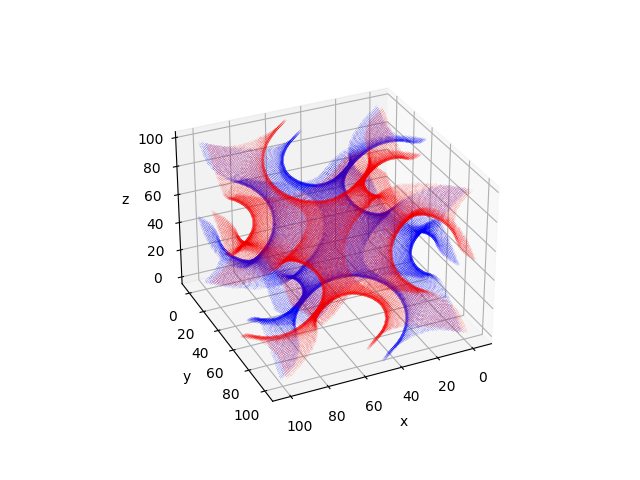

In [6]:
## generate data
verts, faces, normals = genPointCloud(implicit_func=gyroid, res=100)

## extract coordinates of point
x = verts[:,0]
y = verts[:,1]
z = verts[:,2]
## extrude the isosurface along its normal
offset = 5
## negative extrusion
x_lower = x - offset*normals[:,0]
y_lower = y - offset*normals[:,1]
z_lower = z - offset*normals[:,2]
## positive extrusion
x_upper = x + offset*normals[:,0]
y_upper = y + offset*normals[:,1]
z_upper = z + offset*normals[:,2]

## create figure canvas and a 3D axis
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
## plot gyroid isosurfaces
ax.plot(x_lower, y_lower, z_lower, "b.", ms=0.1)
ax.plot(x_upper, y_upper, z_upper, "r.", ms=0.1)
## label axes
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
## show figure
ax.view_init(30, 65)
# fig.show()

# Visualising with mayavi

In [1]:
from mayavi import mlab

# verts, faces, normals = genPointCloud(implicit_func=gyroid, res=10)

# s = mlab.mesh(x, y, z)
# mlab.show()

ImportError: libGL.so.1: cannot open shared object file: No such file or directory